In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold, KFold
import os
from model import MNISTClassifier, COLOR_LIST, GPU_DEVICE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from utils import get_target_distribution

## Parameters

In [2]:
#Parameters for CNN
num_epochs=20
batch_size=128
#Path to saved models
model_path='saved_models/best_model_MNIST.pt'


## Importing our Model: CNN with Mini-Batch Gradient Descent

In [3]:
model = MNISTClassifier(num_epochs=num_epochs,batch_size=batch_size)
model = model.to(GPU_DEVICE)


## Data Preparation

In [4]:
# transforms for images
#The mean and variance are calculated beforehand (0.1305,0.3081)
transform=transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.1305,), (0.3081,))])

# prepare transforms standard to MNIST
mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)

#Load test data and tranfer it to GPU
test_data=model.test_dataloader(mnist_test)

### Data Visualization

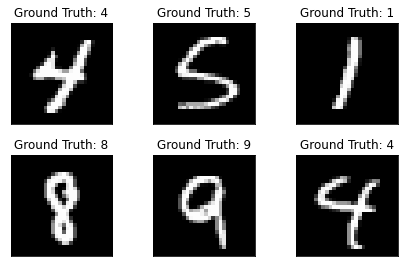

In [5]:
examples = enumerate(model.train_dataloader(mnist_train))
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

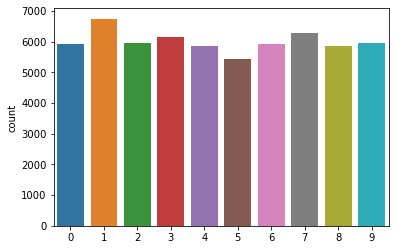

In [6]:
fig, ax = plt.subplots()
target=mnist_train.train_labels
sns.countplot(target.tolist(),ax=ax)
plt.show()

The proportion of classes are roughly similar in the target distribution for our dataset, with class 1 being the most represented.

### Train Dev Split

In [7]:
#Split data into Train and Validation data
train_data, val_data=random_split(mnist_train,[42000,18000])
train_data=model.train_dataloader(train_data)
val_data=model.test_dataloader(val_data)


In [8]:
train_samples=get_target_distribution(train_data,batch_size,42000)
val_samples=get_target_distribution(val_data,batch_size,18000)

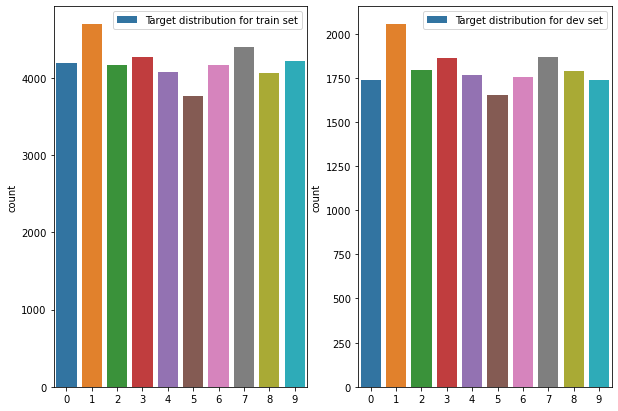

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,7))
sns.countplot(train_samples,label="Target distribution for train set",ax=ax[0])
sns.countplot(val_samples,label="Target distribution for dev set",ax=ax[1])
ax[1].legend()
ax[0].legend()
plt.show()

The proportion of classes are roughly similar for both train and validation set except for class 5 and class 1

### Training

Epoch [1/20], Step [100/329], Loss: 0.2945
Epoch [1/20], Step [200/329], Loss: 0.5760
Epoch [1/20], Step [300/329], Loss: 0.2008

Epoch validation loss: 0.1964038759469986

Epoch [2/20], Step [100/329], Loss: 0.1692
Epoch [2/20], Step [200/329], Loss: 0.1007
Epoch [2/20], Step [300/329], Loss: 0.0639

Epoch validation loss: 0.08672016113996506

Epoch [3/20], Step [100/329], Loss: 0.1404
Epoch [3/20], Step [200/329], Loss: 0.0568
Epoch [3/20], Step [300/329], Loss: 0.0874

Epoch validation loss: 0.06481971591711044

Epoch [4/20], Step [100/329], Loss: 0.0644
Epoch [4/20], Step [200/329], Loss: 0.0566
Epoch [4/20], Step [300/329], Loss: 0.0288

Epoch validation loss: 0.06972530484199524

Epoch [5/20], Step [100/329], Loss: 0.0213
Epoch [5/20], Step [200/329], Loss: 0.0306
Epoch [5/20], Step [300/329], Loss: 0.0523

Epoch validation loss: 0.05699063092470169

Epoch [6/20], Step [100/329], Loss: 0.0672
Epoch [6/20], Step [200/329], Loss: 0.1025
Epoch [6/20], Step [300/329], Loss: 0.0460

E

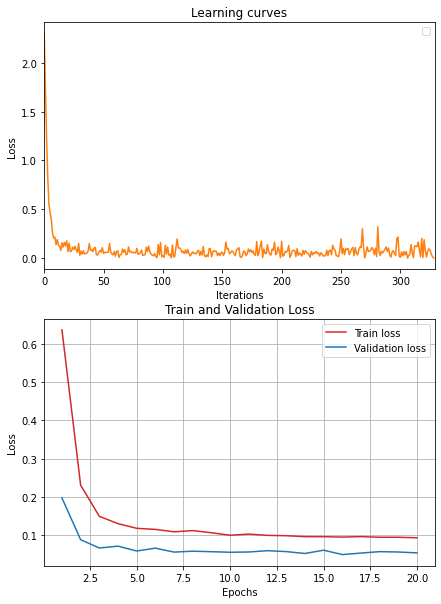

In [10]:

fig, ax = plt.subplots(2,1, figsize=(7,10))
#Compute Traning and get best_model, loss and learning curve across epochs
best_model, best_val_loss, best_learning_curve, epochs_losses = model.compute_training(train_data,val_data)
print('\nBest validation loss: {}\n'.format(best_val_loss))
#Plot best learning curve
model.plot_learning_curve(best_learning_curve,
                            ax=ax[0],
                            color=COLOR_LIST[0])
# Plot train and validation loss
model.plot_train_val_loss(epochs_losses,
                            ax=ax[1])
#Load best model training parameters
model.load_state_dict(best_model)
 
plt.legend()
plt.grid()
plt.show()

** Learning curve **

The learning curve plots the train loss for each iteration for the best epoch (with the lowest validation error). The fluctuations are a characterization of the mini-batch gradient-descent optimization method.

** Losses across epochs **

The training and validation loss have a tendency to decrease with number of epochs. However, validation loss is lower than training loss. It could be  due to:
* a high regularization during training (drop out) and not during validation, which makes it hard for the model to overfit 
*  A validation sample too small or too easy to learn


## Evaluation

In [11]:

test_loss, y_true, y_pred=model.compute_validation(test_data)
print('Test loss: ', test_loss)

Test loss:  0.03678493946790695


Normalized confusion matrix


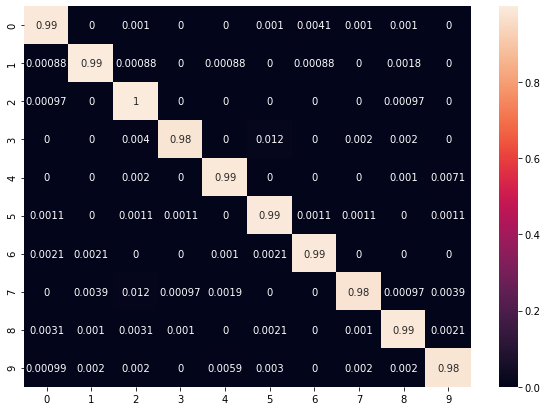

In [12]:
normalize=True
plt.figure(figsize=(10,7))
cm= confusion_matrix(y_true, y_pred.argmax(dim=1))
# Only use the labels that appear in the data
#classes = classes[unique_labels(y_true, y_pred)]
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')
sns.heatmap(cm, annot=True)
plt.show()